# Example Operations

In this example notebook, we will demonstrate how to:

1. Locate the entries in an STM which intersect building polygons;
2. Add year of construction as an attribute to the STM.

## Setup 

### Data

Data used in this notebook can be downloaded from:
- Space-time Matrix in `Zarr` format: [download](https://figshare.com/ndownloader/files/43053616);
- Bulding polygons in `gpkg` format: [download](https://figshare.com/ndownloader/files/41012444).

### Environment

For the Python environment setup, we assume you already started an independent Python environment with Python version higher than 3.10.

To execute this notebook, install `stmtools` with the extra option `demo`:

```sh
pip install stmtools[demo]
```

After installation, execute the notebook in a JupyterLab session, which can be started by running the `jupyterlab` command in your command line:
```bash
jupyter-lab
```

A new tab will be opened in your default browser to execute this notebook.

### Import dependencies

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import stmtools

### Load Space-Time Matrix from Zarr

We load the STM stored in Zarr format. 

In [2]:
path_stm = Path('./stm.zarr')
stmat = xr.open_zarr(path_stm)
stmat = stmat.chunk({"space": 10000, "time": -1}) # Chunk 10000 space, no chunk in time

print(stmat)

<xarray.Dataset>
Dimensions:    (space: 78582, time: 10)
Coordinates:
    azimuth    (space) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (space) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (space) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (space) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (space, time) complex64 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase      (space, time) float32 dask.array<chunksize=(10000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean


### Subset by polygon

We select all entries interlects the building polygons: `bag_light_AMS_WGS84.gpkg`. This takes about 2 minutes.

In [3]:
# Path to the BRP polygon of NL
path_polygon = Path('bag_light_AMS_WGS84.gpkg')

In [4]:
stmat_subset = stmat.stm.subset(method='polygon', polygon=path_polygon)

print(stmat_subset)

<xarray.Dataset>
Dimensions:    (space: 26269, time: 10)
Coordinates:
    azimuth    (space) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (space) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (space) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (space) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (space, time) complex64 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase      (space, time) float32 dask.array<chunksize=(10000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean


### STM enrichment from Polygon file

The year contstruction information is stored in attribute `bouwjaar` (Dutch: building year). Let's query it and assign it to the STM.

In [5]:
fields_to_query = ['bouwjaar']

stmat_enriched = stmat_subset.stm.enrich_from_polygon(path_polygon, fields_to_query)

The assigined data variable `bouwjaar` will be an delayed object. We can run `compute` to peresist the value in memory:

In [6]:
year_construction = stmat_enriched['bouwjaar'].compute()

### Visualize the results

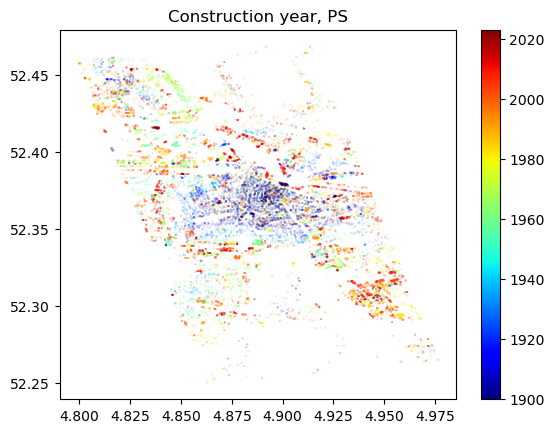

In [7]:
# Visualize results
from matplotlib import pyplot as plt
import matplotlib.cm as cm

colormap = cm.jet

fig, ax = plt.subplots()
plt.title("Construction year, PS")
plt.scatter(stmat_enriched.lon.data, stmat_enriched.lat.data, c=stmat_enriched['bouwjaar'], s=0.004, cmap=colormap)
plt.clim([1900, 2023])
plt.colorbar()